# Quadratic Assignment Problem

Assigning Facilities to Locations

In [2]:
# Example of cost matrix for the facility location problem
# Distance between locations
locations = [
        [0, 1, 2, 3],
        [1, 0, 4, 2],
        [2, 4, 0, 1],
        [3, 2, 1, 0]
    ]
# like distance

# Communication/Interaction Between Facilities
facilities = [
        [0, 2, 3, 1],
        [2, 0, 1, 4],
        [3, 1, 0, 2],
        [1, 4, 2, 0]
    ]
# like packages sent between facilities per day

In [5]:
from typing import List

import matplotlib.pyplot as plt
import networkx as nx

def draw_graph(title: str, location_name: List[str], adj_matrix: List[List[List[int]]], edge_labels: List[str]):
  G = nx.Graph()
  G.add_nodes_from(location_name)
  for i in range(len(location_name)):
    for j in range(i+1, len(location_name)):
      edge_label = ""
      for k, label in enumerate(edge_labels):
        edge_label += f"{label} = {adj_matrix[k][i][j]}\n"
      G.add_edge(location_name[i], location_name[j], weight=adj_matrix[k][i][j], label=edge_label)
  
  fig = plt.figure(figsize=(8, 8))
  pos = nx.spring_layout(G, k=0.5, seed=128)
  nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold')
  labels = nx.get_edge_attributes(G, 'label')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.3)
  plt.title(title)
  plt.show()


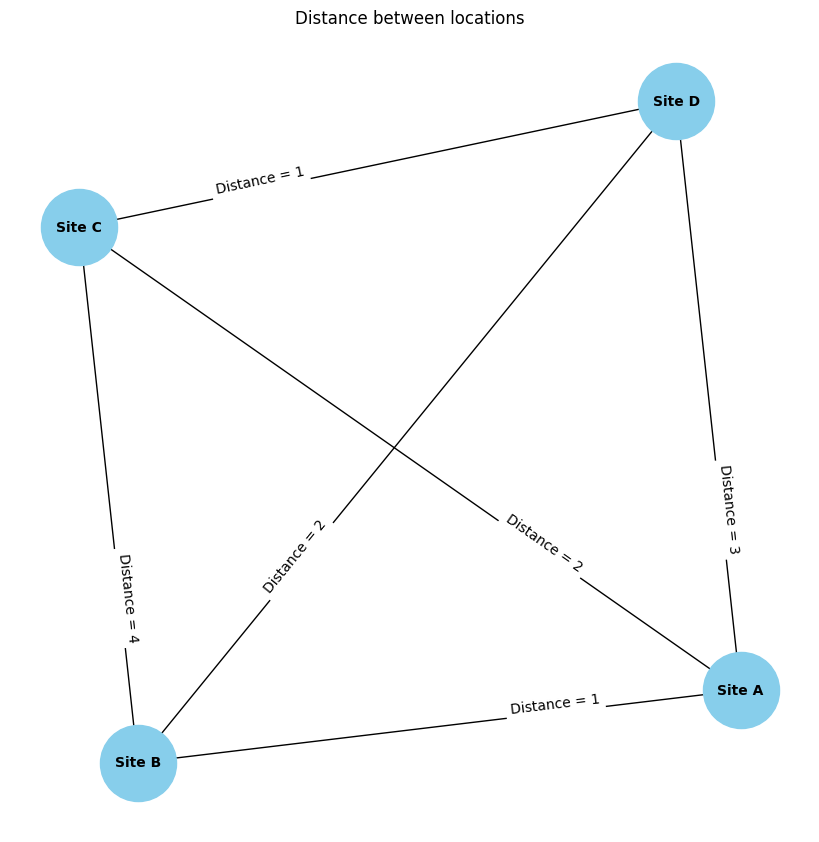

In [6]:
location_name = ["Site A", "Site B", "Site C", "Site D"]

# Draw Graph of locations distance
draw_graph("Distance between locations", location_name, [locations], ["Distance"])

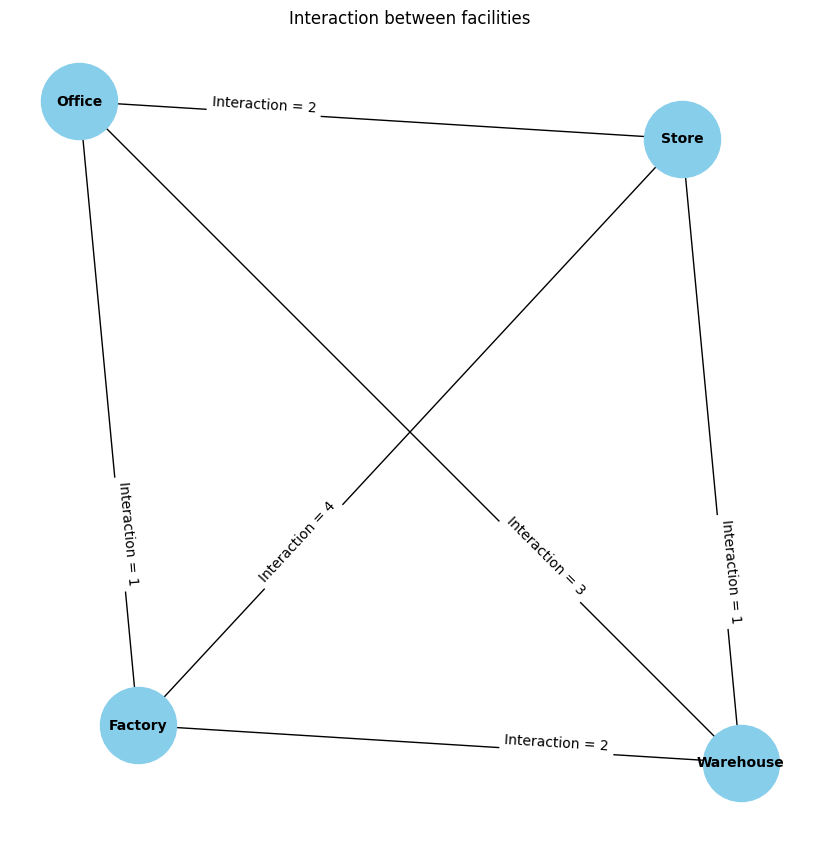

In [7]:
facility_name = ['Warehouse', 'Factory', 'Office', 'Store']

draw_graph("Interaction between facilities", facility_name, [facilities], ["Interaction"])

Site A is assigned to Warehouse
Site B is assigned to Factory
Site C is assigned to Office
Site D is assigned to Store
Total Cost: 50


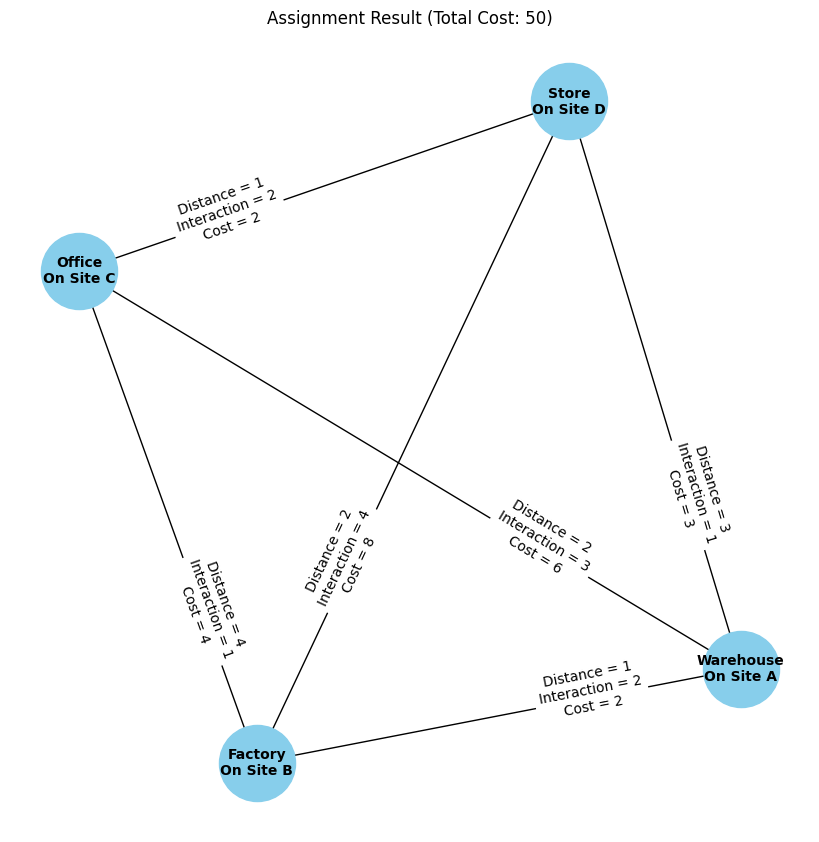

In [9]:
def assign_facilities(
    assign: List[int],
    location_name=location_name,
    facility_name=facility_name,
    distance_matrix=locations,
    interaction_matrix=facilities,
    ):
  size = len(assign)

  # Create Three empty matrix with size of size*size
  # distance_matrix = [[0 for _ in range(size)] for _ in range(size)]
  mapped_interaction_matrix = [[0 for _ in range(size)] for _ in range(size)]
  cost_matrix = [[0 for _ in range(size)] for _ in range(size)]

  node_labels = []
  for i in range(size):
    print(f"{location_name[i]} is assigned to {facility_name[assign[i]]}")
    node_labels.append(f"{facility_name[assign[i]]}\nOn {location_name[i]}")

  total_cost = 0
  for i in range(size):
    for j in range(size):
      # distance_matrix[i][j] = locations[i][j]
      mapped_interaction_matrix[i][j] = interaction_matrix[assign[i]][assign[j]]
      cost_matrix[i][j] = distance_matrix[i][j] * mapped_interaction_matrix[i][j]
      total_cost += cost_matrix[i][j]

  print(f"Total Cost: {total_cost}")
  
  draw_graph(f"Assignment Result (Total Cost: {total_cost})", node_labels, [distance_matrix, mapped_interaction_matrix, cost_matrix], ["Distance", "Interaction", "Cost"])

assign_facilities([0, 1, 2, 3])

## Optimal Solution with Brute Force

Site A is assigned to Warehouse
Site B is assigned to Office
Site C is assigned to Factory
Site D is assigned to Store
Total Cost: 44


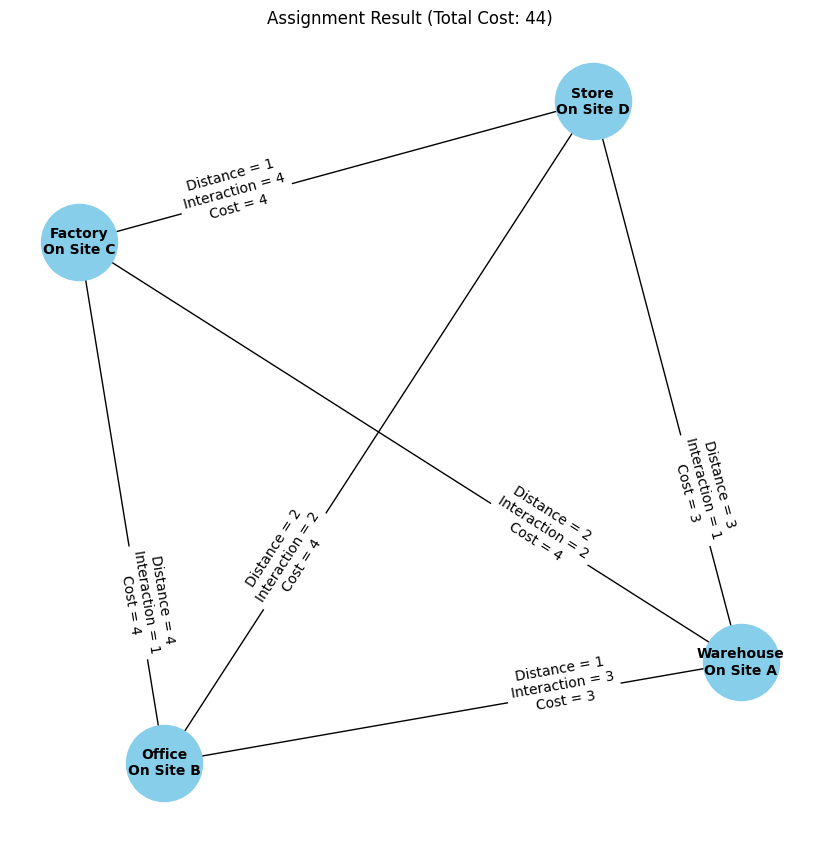

In [10]:
# Brute Force Solution
bf_solution = [0, 2, 1, 3]
assign_facilities(bf_solution)

## Transforming problem into QUBO

In [11]:
def obj_to_latex(obj):
  return " + ".join(list(map(
  lambda x: x.strip().replace(" ", " \\cdot "),
  str(obj).split("+"))))

def con_to_latex(con):
  md = ''
  for c in con:
    lhs, rhs = str(c).split("==")
    rhs_value = rhs.strip().split(" ")[0]
    md += f"${lhs.strip()} = {rhs_value.strip()}$  \n"
  return md

In [43]:
from IPython.display import display, Markdown

# Amplify Model
from amplify import VariableGenerator, Model, equal_to, one_hot, Poly, ConstraintList

def create_qp_model(distance_matrix=locations, interaction_matrix=facilities):
  assert(len(distance_matrix) == len(interaction_matrix))
  size = len(distance_matrix)

  gen = VariableGenerator()
  # Facility i on Site j
  q = gen.array(type="Binary", shape=(size, size), name="q")

  obj = Poly()

  for i1 in range(size):
    for j1 in range(size):
      for i2 in range(size):
        for j2 in range(size):
          if i1 != i2 and j1 != j2:
            obj += q[i1, j1] * q[i2, j2] * interaction_matrix[i1][i2] * distance_matrix[j1][j2]

  c = ConstraintList()

  for i in range(size):
    c += equal_to(q[i], 1)
    c += equal_to(q[0, i] + q[1, i] + q[2, i] + q[3, i], 1)

  model = obj + c

  return {"model": model, "obj": obj, "c": c, "q": q}

qp_model = create_qp_model()

display(Markdown("### Objective: Minimize"))
display(Markdown(f"${obj_to_latex(qp_model["obj"])}$"))


display(Markdown("### Constraint:"))
display(Markdown(con_to_latex(qp_model["c"])))

model = qp_model["model"]

### Objective: Minimize

$4 \cdot q_{0,0} \cdot q_{1,1} + 8 \cdot q_{0,0} \cdot q_{1,2} + 12 \cdot q_{0,0} \cdot q_{1,3} + 6 \cdot q_{0,0} \cdot q_{2,1} + 12 \cdot q_{0,0} \cdot q_{2,2} + 18 \cdot q_{0,0} \cdot q_{2,3} + 2 \cdot q_{0,0} \cdot q_{3,1} + 4 \cdot q_{0,0} \cdot q_{3,2} + 6 \cdot q_{0,0} \cdot q_{3,3} + 4 \cdot q_{0,1} \cdot q_{1,0} + 16 \cdot q_{0,1} \cdot q_{1,2} + 8 \cdot q_{0,1} \cdot q_{1,3} + 6 \cdot q_{0,1} \cdot q_{2,0} + 24 \cdot q_{0,1} \cdot q_{2,2} + 12 \cdot q_{0,1} \cdot q_{2,3} + 2 \cdot q_{0,1} \cdot q_{3,0} + 8 \cdot q_{0,1} \cdot q_{3,2} + 4 \cdot q_{0,1} \cdot q_{3,3} + 8 \cdot q_{0,2} \cdot q_{1,0} + 16 \cdot q_{0,2} \cdot q_{1,1} + 4 \cdot q_{0,2} \cdot q_{1,3} + 12 \cdot q_{0,2} \cdot q_{2,0} + 24 \cdot q_{0,2} \cdot q_{2,1} + 6 \cdot q_{0,2} \cdot q_{2,3} + 4 \cdot q_{0,2} \cdot q_{3,0} + 8 \cdot q_{0,2} \cdot q_{3,1} + 2 \cdot q_{0,2} \cdot q_{3,3} + 12 \cdot q_{0,3} \cdot q_{1,0} + 8 \cdot q_{0,3} \cdot q_{1,1} + 4 \cdot q_{0,3} \cdot q_{1,2} + 18 \cdot q_{0,3} \cdot q_{2,0} + 12 \cdot q_{0,3} \cdot q_{2,1} + 6 \cdot q_{0,3} \cdot q_{2,2} + 6 \cdot q_{0,3} \cdot q_{3,0} + 4 \cdot q_{0,3} \cdot q_{3,1} + 2 \cdot q_{0,3} \cdot q_{3,2} + 2 \cdot q_{1,0} \cdot q_{2,1} + 4 \cdot q_{1,0} \cdot q_{2,2} + 6 \cdot q_{1,0} \cdot q_{2,3} + 8 \cdot q_{1,0} \cdot q_{3,1} + 16 \cdot q_{1,0} \cdot q_{3,2} + 24 \cdot q_{1,0} \cdot q_{3,3} + 2 \cdot q_{1,1} \cdot q_{2,0} + 8 \cdot q_{1,1} \cdot q_{2,2} + 4 \cdot q_{1,1} \cdot q_{2,3} + 8 \cdot q_{1,1} \cdot q_{3,0} + 32 \cdot q_{1,1} \cdot q_{3,2} + 16 \cdot q_{1,1} \cdot q_{3,3} + 4 \cdot q_{1,2} \cdot q_{2,0} + 8 \cdot q_{1,2} \cdot q_{2,1} + 2 \cdot q_{1,2} \cdot q_{2,3} + 16 \cdot q_{1,2} \cdot q_{3,0} + 32 \cdot q_{1,2} \cdot q_{3,1} + 8 \cdot q_{1,2} \cdot q_{3,3} + 6 \cdot q_{1,3} \cdot q_{2,0} + 4 \cdot q_{1,3} \cdot q_{2,1} + 2 \cdot q_{1,3} \cdot q_{2,2} + 24 \cdot q_{1,3} \cdot q_{3,0} + 16 \cdot q_{1,3} \cdot q_{3,1} + 8 \cdot q_{1,3} \cdot q_{3,2} + 4 \cdot q_{2,0} \cdot q_{3,1} + 8 \cdot q_{2,0} \cdot q_{3,2} + 12 \cdot q_{2,0} \cdot q_{3,3} + 4 \cdot q_{2,1} \cdot q_{3,0} + 16 \cdot q_{2,1} \cdot q_{3,2} + 8 \cdot q_{2,1} \cdot q_{3,3} + 8 \cdot q_{2,2} \cdot q_{3,0} + 16 \cdot q_{2,2} \cdot q_{3,1} + 4 \cdot q_{2,2} \cdot q_{3,3} + 12 \cdot q_{2,3} \cdot q_{3,0} + 8 \cdot q_{2,3} \cdot q_{3,1} + 4 \cdot q_{2,3} \cdot q_{3,2}$

### Constraint:

$q_{0,0} + q_{0,1} + q_{0,2} + q_{0,3} = 1$  
$q_{0,0} + q_{1,0} + q_{2,0} + q_{3,0} = 1$  
$q_{1,0} + q_{1,1} + q_{1,2} + q_{1,3} = 1$  
$q_{0,1} + q_{1,1} + q_{2,1} + q_{3,1} = 1$  
$q_{2,0} + q_{2,1} + q_{2,2} + q_{2,3} = 1$  
$q_{0,2} + q_{1,2} + q_{2,2} + q_{3,2} = 1$  
$q_{3,0} + q_{3,1} + q_{3,2} + q_{3,3} = 1$  
$q_{0,3} + q_{1,3} + q_{2,3} + q_{3,3} = 1$  


In [44]:
def solution_to_map(result, variables, size=4):
  mapped_solution = [-1] * size

  for i in range(size):
    for j in range(size):
      if result.best.values[variables[i, j]] == 1:
        # print(f"{location_name[j]} is assigned to {faculty_name[i]}")
        mapped_solution[j] = i

  return mapped_solution

In [45]:
# Run on Fixstars Amplify
from dotenv import load_dotenv
import os

load_dotenv()

FIXSTAR_TOKEN = os.getenv('FIXSTAR_TOKEN')
DWAVE_TOKEN = os.getenv('DWAVE_TOKEN')

In [46]:
from amplify import solve
from datetime import timedelta

## Fixstars Amplify AE

In [24]:
# Initialise Fixstars Client
from amplify import FixstarsClient

if FIXSTAR_TOKEN is None:
  raise Exception("Please set FIXSTAR_TOKEN in .env file")

clientFS = FixstarsClient()
clientFS.token = FIXSTAR_TOKEN
clientFS.parameters.timeout = timedelta(milliseconds=10000)

# Solve set partitioning and view result
result = solve(model, clientFS)

print(result.best.objective)
print(result.best.values)

RuntimeError: result has no feasible solution

In [25]:
print(result.client_result)

{"execution_time":{"annealing_time":9970.908105999999,"queue_time":0.08735799999999999,"cpu_time":0.435017,"time_stamps":[31.872166999999997]},"energies":[2.0],"spins":[[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1]],"feasibilities":[false],"execution_parameters":{"num_gpus":1,"timeout":10000,"num_iterations":138,"penalty_calibration":true,"penalty_multipliers":[2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0],"version":"v0.8.7-V100"},"message":""}


## Gurobi

In [48]:
from amplify import GurobiClient

clientG = GurobiClient(
  library_path="/Library/gurobi1103/macos_universal2/lib/libgurobi110.dylib"
)
clientG.parameters.time_limit = timedelta(seconds=100)

resultG = solve(model, clientG)

print(resultG.best.objective)
print(resultG.best.values)

Set parameter Username
44.0
{q_{0,0}: 1, q_{0,1}: 0, q_{0,2}: 0, q_{0,3}: 0, q_{1,0}: 0, q_{1,1}: 0, q_{1,2}: 1, q_{1,3}: 0, q_{2,0}: 0, q_{2,1}: 1, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 0, q_{3,2}: 0, q_{3,3}: 1}
Academic license - for non-commercial use only - expires 2025-10-14


Site A is assigned to Warehouse
Site B is assigned to Office
Site C is assigned to Factory
Site D is assigned to Store
Total Cost: 44


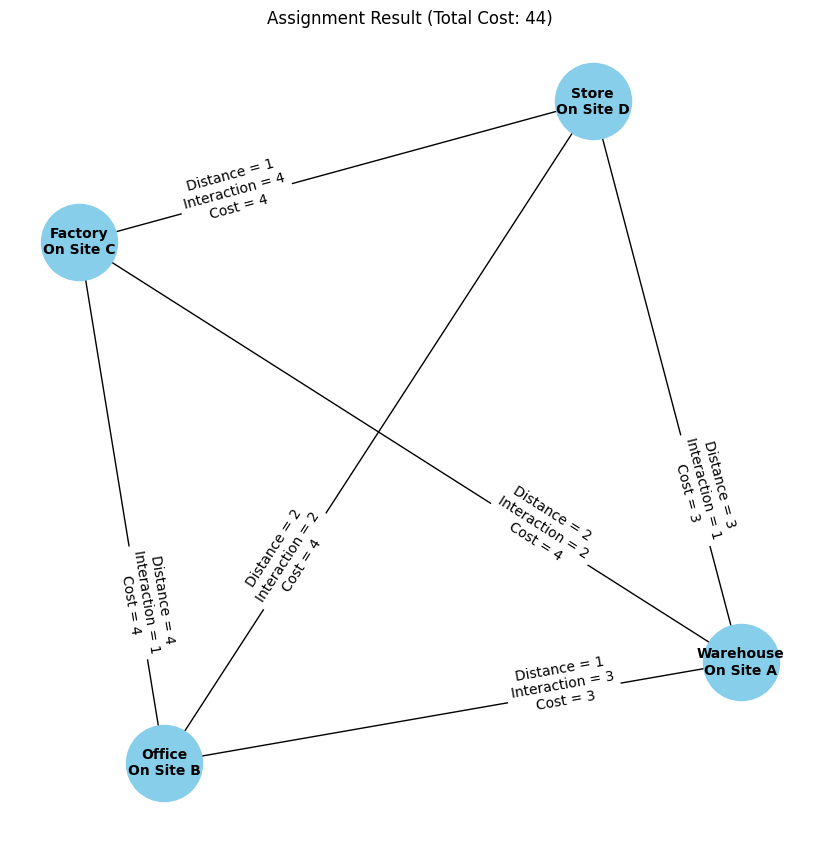

In [49]:
assign_facilities(solution_to_map(resultG, qp_model["q"]))

## D-Wave

In [29]:
from amplify import DWaveSamplerClient

if DWAVE_TOKEN is None:
  raise Exception("Please set DWAVE_TOKEN in .env file")

clientDWave = DWaveSamplerClient()
clientDWave.token = DWAVE_TOKEN
clientDWave.solver = "Advantage_system6.4"
clientDWave.parameters.num_reads = 1000

result = solve(model, clientDWave)

print(result.best.objective)
print(result.best.values)

RuntimeError: result has no feasible solution

## Try with Smaller Constraint

In [50]:
s_distance = [
        [0, 1, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [0, 1, 0, 0]
    ]

s_interaction = [
        [0, 1, 0, 1],
        [1, 0, 1, 1],
        [0, 1, 0, 0],
        [1, 1, 0, 0]
    ]

s_model = create_qp_model(s_distance, s_interaction)

display(Markdown("### Objective: Minimize"))
display(Markdown(f"${obj_to_latex(s_model["obj"])}$"))


display(Markdown("### Constraint:"))
display(Markdown(con_to_latex(s_model["c"])))

### Objective: Minimize

$2 \cdot q_{0,0} \cdot q_{1,1} + 2 \cdot q_{0,0} \cdot q_{1,2} + 2 \cdot q_{0,0} \cdot q_{3,1} + 2 \cdot q_{0,0} \cdot q_{3,2} + 2 \cdot q_{0,1} \cdot q_{1,0} + 2 \cdot q_{0,1} \cdot q_{1,2} + 2 \cdot q_{0,1} \cdot q_{1,3} + 2 \cdot q_{0,1} \cdot q_{3,0} + 2 \cdot q_{0,1} \cdot q_{3,2} + 2 \cdot q_{0,1} \cdot q_{3,3} + 2 \cdot q_{0,2} \cdot q_{1,0} + 2 \cdot q_{0,2} \cdot q_{1,1} + 2 \cdot q_{0,2} \cdot q_{3,0} + 2 \cdot q_{0,2} \cdot q_{3,1} + 2 \cdot q_{0,3} \cdot q_{1,1} + 2 \cdot q_{0,3} \cdot q_{3,1} + 2 \cdot q_{1,0} \cdot q_{2,1} + 2 \cdot q_{1,0} \cdot q_{2,2} + 2 \cdot q_{1,0} \cdot q_{3,1} + 2 \cdot q_{1,0} \cdot q_{3,2} + 2 \cdot q_{1,1} \cdot q_{2,0} + 2 \cdot q_{1,1} \cdot q_{2,2} + 2 \cdot q_{1,1} \cdot q_{2,3} + 2 \cdot q_{1,1} \cdot q_{3,0} + 2 \cdot q_{1,1} \cdot q_{3,2} + 2 \cdot q_{1,1} \cdot q_{3,3} + 2 \cdot q_{1,2} \cdot q_{2,0} + 2 \cdot q_{1,2} \cdot q_{2,1} + 2 \cdot q_{1,2} \cdot q_{3,0} + 2 \cdot q_{1,2} \cdot q_{3,1} + 2 \cdot q_{1,3} \cdot q_{2,1} + 2 \cdot q_{1,3} \cdot q_{3,1}$

### Constraint:

$q_{0,0} + q_{0,1} + q_{0,2} + q_{0,3} = 1$  
$q_{0,0} + q_{1,0} + q_{2,0} + q_{3,0} = 1$  
$q_{1,0} + q_{1,1} + q_{1,2} + q_{1,3} = 1$  
$q_{0,1} + q_{1,1} + q_{2,1} + q_{3,1} = 1$  
$q_{2,0} + q_{2,1} + q_{2,2} + q_{2,3} = 1$  
$q_{0,2} + q_{1,2} + q_{2,2} + q_{3,2} = 1$  
$q_{3,0} + q_{3,1} + q_{3,2} + q_{3,3} = 1$  
$q_{0,3} + q_{1,3} + q_{2,3} + q_{3,3} = 1$  


Site A is assigned to Warehouse
Site B is assigned to Factory
Site C is assigned to Office
Site D is assigned to Store
Total Cost: 6


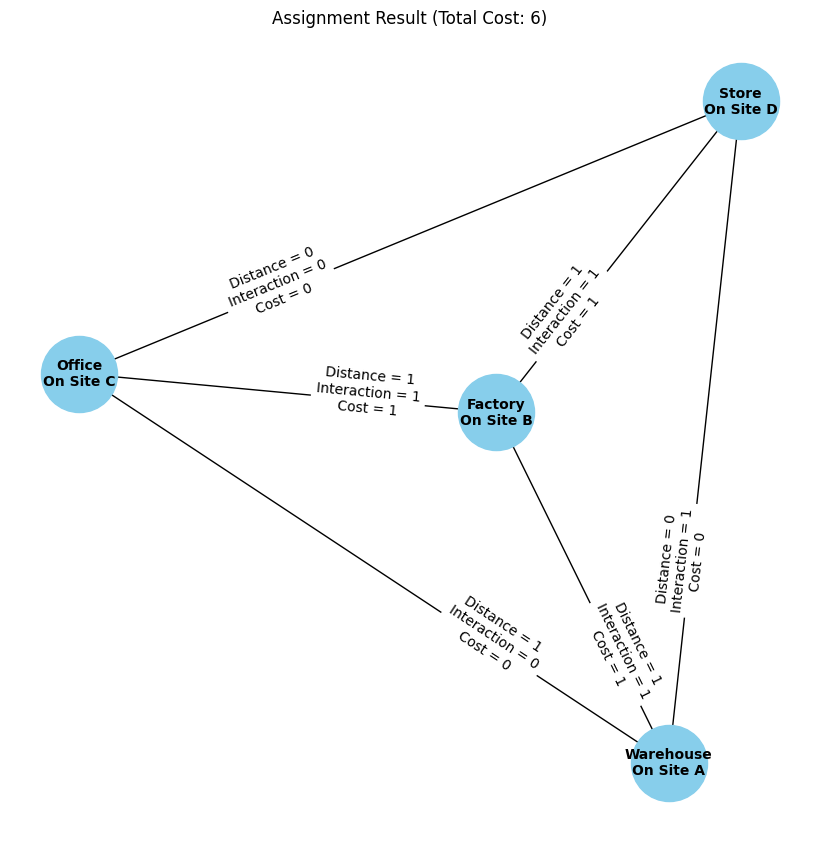

In [51]:
# Random Solution

assign_facilities([0, 1, 2, 3], distance_matrix=s_distance, interaction_matrix=s_interaction)

## Find best solution with Gurobi

Because it is easiest and fastest

4.0
{q_{0,0}: 1, q_{0,1}: 0, q_{0,2}: 0, q_{0,3}: 0, q_{1,0}: 0, q_{1,1}: 0, q_{1,2}: 1, q_{1,3}: 0, q_{2,0}: 0, q_{2,1}: 1, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 0, q_{3,1}: 0, q_{3,2}: 0, q_{3,3}: 1}
Site A is assigned to Warehouse
Site B is assigned to Office
Site C is assigned to Factory
Site D is assigned to Store
Total Cost: 4
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-14


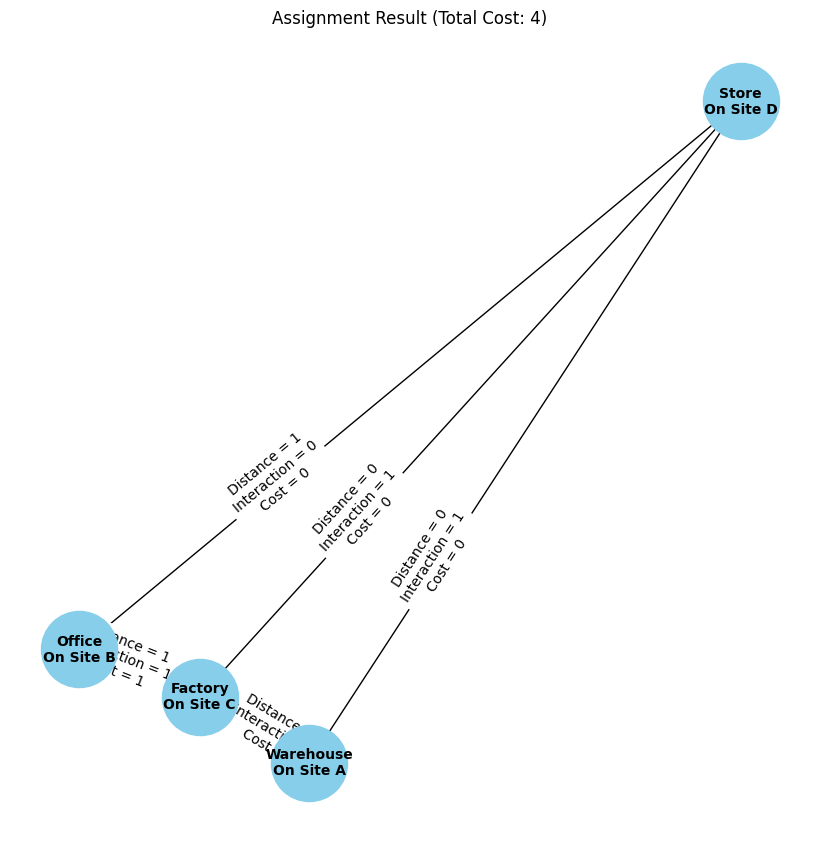

In [52]:
result_s_gurobi = solve(s_model["model"], clientG)

print(result_s_gurobi.best.objective)
print(result_s_gurobi.best.values)
assign_facilities(solution_to_map(result_s_gurobi, s_model["q"]), distance_matrix=s_distance, interaction_matrix=s_interaction)

## Giving Fixstars and D-Wave second try

4.0
{q_{0,0}: 0, q_{0,1}: 0, q_{0,2}: 1, q_{0,3}: 0, q_{1,0}: 0, q_{1,1}: 0, q_{1,2}: 0, q_{1,3}: 1, q_{2,0}: 0, q_{2,1}: 1, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 1, q_{3,1}: 0, q_{3,2}: 0, q_{3,3}: 0}
Site A is assigned to Store
Site B is assigned to Office
Site C is assigned to Warehouse
Site D is assigned to Factory
Total Cost: 4


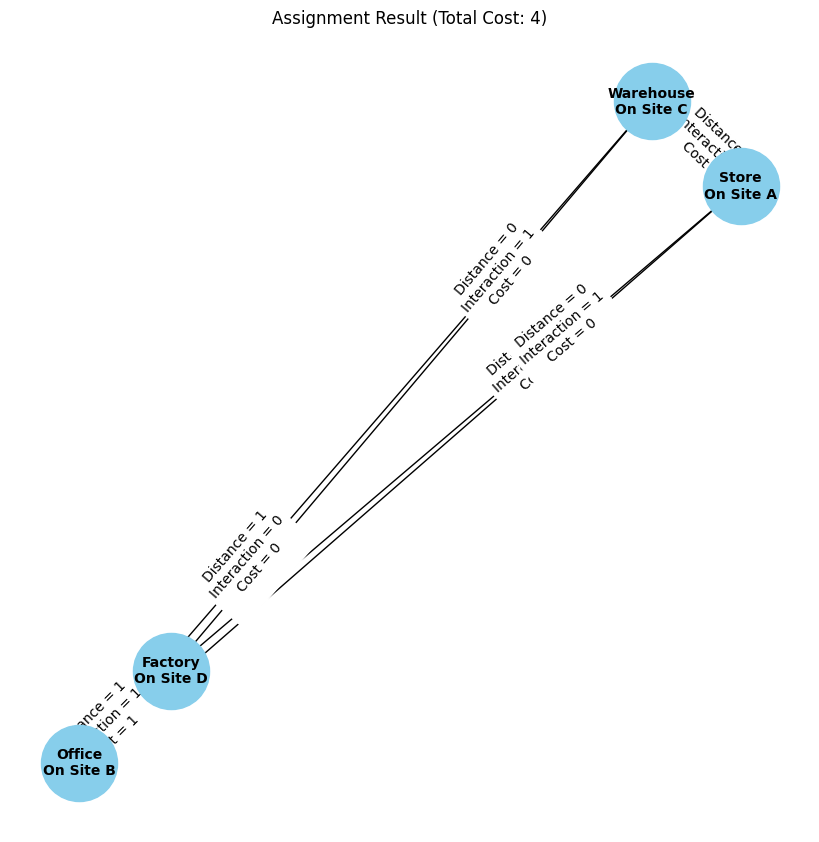

In [53]:
result_s_fixstars = solve(s_model["model"], clientFS)

print(result_s_fixstars.best.objective)
print(result_s_fixstars.best.values)
assign_facilities(solution_to_map(result_s_fixstars, s_model["q"]), distance_matrix=s_distance, interaction_matrix=s_interaction)

4.0
{q_{0,0}: 0, q_{0,1}: 0, q_{0,2}: 1, q_{0,3}: 0, q_{1,0}: 0, q_{1,1}: 0, q_{1,2}: 0, q_{1,3}: 1, q_{2,0}: 0, q_{2,1}: 1, q_{2,2}: 0, q_{2,3}: 0, q_{3,0}: 1, q_{3,1}: 0, q_{3,2}: 0, q_{3,3}: 0}
Site A is assigned to Store
Site B is assigned to Office
Site C is assigned to Warehouse
Site D is assigned to Factory
Total Cost: 4


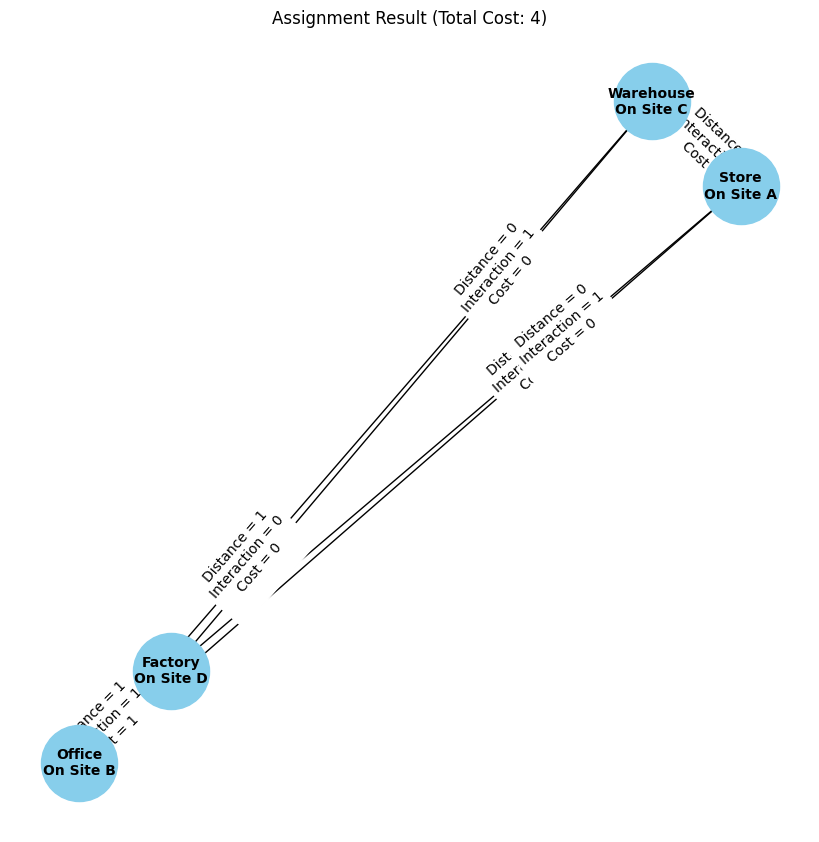

In [55]:
result_s_dwave = solve(s_model["model"], clientDWave)

print(result_s_dwave.best.objective)
print(result_s_dwave.best.values)
assign_facilities(solution_to_map(result_s_dwave, s_model["q"]), distance_matrix=s_distance, interaction_matrix=s_interaction)

## Conclusion

### QAP Complexity
- Number of Variables is $\mathcal{O}(n^2)$
- Terms of Objective is $\mathcal{O}(n^4)$
- Number of constraints is $\mathcal{O}(n)$

## Preliminary Conclusion

Gurobi likely does not use Annealing method and can solve the problem easily

However, Annealing like Qiskit, D-Wave, and Fixstars failed to solve problem
that is too big.